In [25]:
import os
from PIL import Image as PILImage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [26]:
# GPU 설정하기
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [27]:
# 자신의 폴더 경로에 맞게 재지정해주세요.
root_path = './cityscapes_data'

data_dir = root_path

# data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
train_dir = os.path.join(data_dir, "train")

# data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
val_dir = os.path.join(data_dir, "val")

In [28]:
# train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
train_fns = os.listdir(train_dir)

# val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


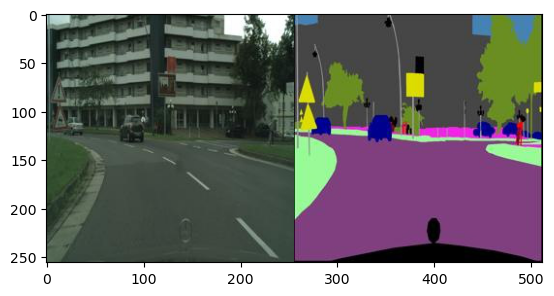

In [29]:
# train_dir(문자열)와 train_fns[0](문자열)의 경로를 결합하여 sample_image_fp(샘플 이미지의 경로)에 저장합니다.
sample_image_fp = os.path.join(train_dir, train_fns[0])

# PIL 라이브러리의 Image 모듈을 사용하여, sample_image_fp를 불러옵니다.
sample_image = PILImage.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [30]:
# Output Label 정의하기
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

num_classes = 10

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

(1000, 3)


c:\Users\7johs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\7johs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=10)

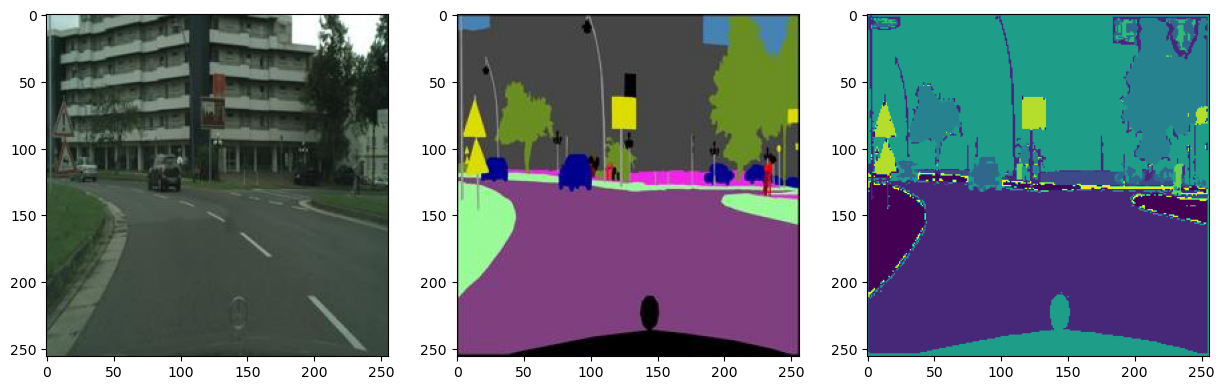

In [31]:
# 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
def split_image(image) :
   image = np.array(image)
   
   # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
   # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

# 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [32]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
  #image_dir : 이미지 파일들이 저장된 디렉토리 경로
  #label_model : 이미지에 있는 객체의 군집을 예측하기 위해 사용되는 K-means 군집화 모델
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir) #지정된 디렉토리 내의 파일 목록 가져와 저장
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.image_fns) #디렉토리 내 이미지 파일 수 반환
    
  def __getitem__(self, index) :
    #지정된 인덱스의 이미지 파일 이름을 가져와, 전체 파일 경로를 구성
    #해당 파일 경로에서 이미지를 열고, 이를 Numpy 배열로 변환
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = PILImage.open(image_fp)
    image = np.array(image)

    #이미지를 두 부분(원본 이미지와 레이블 이미지)로 분리
    cityscape, label = self.split_image(image)

    #원본 이미지에 Mirroing Extrapolate 기법 적용
    cityscape = self.apply_mirroring(cityscape)

    # 이미지를 타일로 나눔
    tiles = self.tile_image(cityscape, tile_size=128, overlap=64)

    # 각 타일에 대한 변환 적용
    transformed_tiles = torch.stack([self.transform(tile) for tile in tiles])

    #군집화를 통해 얻은 정보(각 픽셀이 속한 군집의 정보)를 원래 이미지 형태로 다시 만듦 
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    #군집화 결과를 텐서로 변환
    label_class = torch.Tensor(label_class).long()
    
    return transformed_tiles, label_class
  
  def apply_mirroring(self, image):
    #이미지의 가장자리에 Mirroring 적용
    #세로뱡항(상하)과 가로 방향(좌우)에 각각 64픽셀의 패딩 추가
    #채널 차원에는 패딩을 추가하지 X
    #reflect : padding 영역에 원본 이미지의 반사(reflection) 적용
    mirrored_image = np.pad(image, pad_width=((64, 64), (64, 64), (0, 0)), mode='reflect')
    return mirrored_image 
  
  
  def tile_image(self, image, tile_size, overlap):
      #분할된 타일들을 저장할 리스트
      tiles = []
      #tile_size에 지정된 크기의 정사각형 타일로 나눔
      #tile_size - overlap만큼 이동하면서 반복
      for i in range(0, image.shape[0] - overlap, tile_size - overlap):
          for j in range(0, image.shape[1] - overlap, tile_size - overlap):
              tiles.append(image[i:i + tile_size, j:j + tile_size])
      return tiles

  
  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label
    
  
  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [33]:
dataset = CityscapeDataset(train_dir, label_model)
transformed_tiles, label_class = dataset[0]
print(transformed_tiles.shape)
print(label_class.shape)

torch.Size([25, 3, 128, 128])
torch.Size([256, 256])


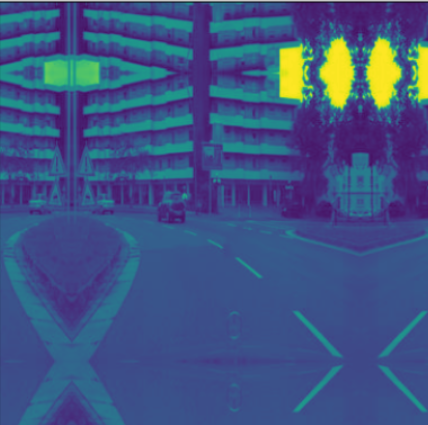

In [34]:
#overlap tile 적용 전 mirroring 결과
from IPython.display import Image
Image("./mirroring.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


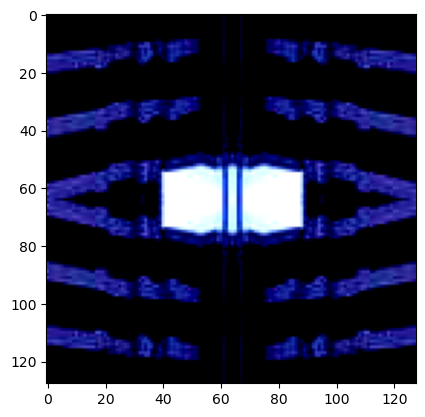

In [35]:
# 첫 번째 타일을 PyTorch 텐서에서 NumPy 배열로 변환
# (channels, height, width) -> (height, width, channels
plt.imshow(transformed_tiles[0].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


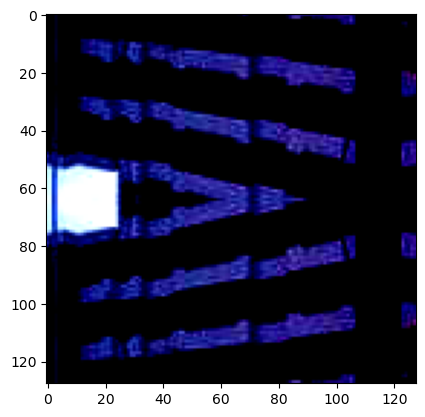

In [36]:
plt.imshow(transformed_tiles[1].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


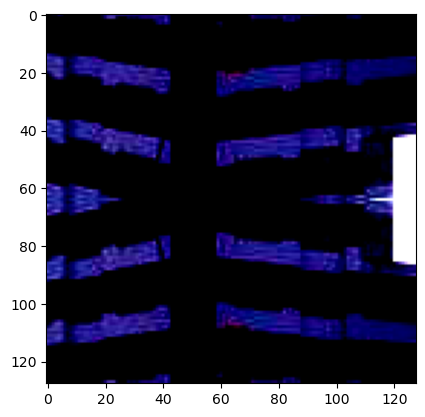

In [37]:
image_to_show = transformed_tiles[2].permute(1, 2, 0)
plt.imshow(image_to_show)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


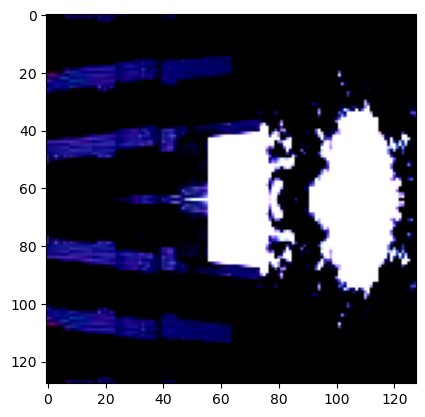

In [38]:
image_to_show = transformed_tiles[3].permute(1, 2, 0)
plt.imshow(image_to_show)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


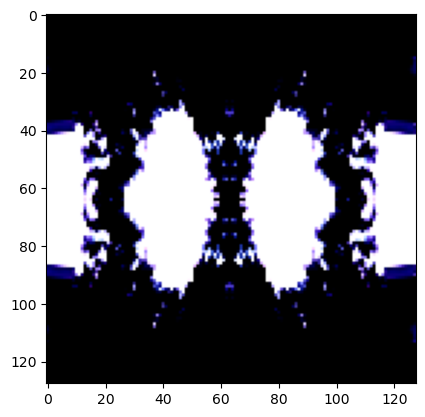

In [39]:
image_to_show = transformed_tiles[4].permute(1, 2, 0)
plt.imshow(image_to_show)
plt.show()

In [60]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
	# 1x1 convolution layer 추가
        self.output1 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) 
        contracting_12_out = self.contracting_12(contracting_11_out) 
        contracting_21_out = self.contracting_21(contracting_12_out) 
        contracting_22_out = self.contracting_22(contracting_21_out) 
        contracting_31_out = self.contracting_31(contracting_22_out) 
        contracting_32_out = self.contracting_32(contracting_31_out) 
        contracting_41_out = self.contracting_41(contracting_32_out) 
        contracting_42_out = self.contracting_42(contracting_41_out) 
        middle_out = self.middle(contracting_42_out)
        expansive_11_out = self.expansive_11(middle_out) 
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) 
        expansive_21_out = self.expansive_21(expansive_12_out) 
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) 
        expansive_31_out = self.expansive_31(expansive_22_out) 
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) 
        expansive_41_out = self.expansive_41(expansive_32_out)
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) 
        output_out = self.output(expansive_42_out) 
        output_out1 = self.output(output_out)
        
        return output_out1 

In [61]:
# 하이퍼파라미터
epochs = 10
lr = 0.01
batch_size = 4
num_tiles_per_image = 25  # 가정: 한 이미지가 25개의 타일로 구성
num_classes =1

# 데이터 로더 및 모델 설정
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)
model = UNet(num_classes=num_classes).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 훈련
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0

    for tiles, labels in tqdm(data_loader, total=len(data_loader), leave=False):
        # tiles: [batch_size, num_tiles, channels, height, width]
        # labels: [batch_size, height, width]

        batch_outputs = []  # 배치 단위로 결과를 저장할 리스트

        for i in range(tiles.size(1)):  # num_tiles
            tile = tiles[:, i, :, :, :].to(device)  # [batch_size, channels, height, width]
            label = labels.to(device)

            optimizer.zero_grad()
            output = model(tile)  # 모델에 타일 입력
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            step_losses.append(loss.item())
            batch_outputs.append(output.cpu().detach())  # 결과 저장

        # 모든 타일의 출력을 하나의 이미지로 재구성
        final_output = torch.cat([x for x in batch_outputs], dim=2)  # dim을 조정하여 타일 병합

        # 결과 이미지와 레이블 간 손실 계산
        final_loss = criterion(final_output, labels)
        print(f"Final loss for batch: {final_loss.item()}")

    epoch_losses.append(epoch_loss / len(data_loader))

print("Training completed.")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

RuntimeError: size mismatch (got input: [4, 64, 128, 128] , target: [4, 256, 256]

In [ ]:
# 모델 평가하기
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)
# 출력결과 => test_batch_size에 따라 8은 변할 수 있음
torch.Size([8, 64, 256, 256])
torch.Size([8, 256, 256])
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()